# Vehicle Access Data by Census Tract

I will now incorporate the Census data on household vehicle ownership by Census Tract, to then map onto this food data.

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import networkx as nx
import contextily as ctx
import plotly.express as px
import osmnx as ox

In [2]:
va=pd.read_csv('data/2021_ACS_vehicles_available.csv')

Now, I want to check out the data and see how much data there is and what it looks like.

In [3]:
va.shape

(206, 68)

In [4]:
va.head()

,Geo_FIPS,Geo_QName,Geo_FILEID,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_LOGRECNO,Geo_US,Geo_REGION,Geo_DIVISION,...,SE_A10030_004,SE_A10030_005,SE_A10030_006,SE_A10030_007,PCT_SE_A10030_002,PCT_SE_A10030_003,PCT_SE_A10030_004,PCT_SE_A10030_005,PCT_SE_A10030_006,PCT_SE_A10030_007
0,11001000101,"Census Tract 1.01, District of Columbia, Distr...",ACSSF,dc,140,0,9,NaN,NaN,NaN,...,120,10,0,0,32.68,50.26,15.75,1.31,0.00,0.0
1,11001000102,"Census Tract 1.02, District of Columbia, Distr...",ACSSF,dc,140,0,10,NaN,NaN,NaN,...,447,74,0,0,20.64,50.53,24.74,4.10,0.00,0.0
2,11001000201,"Census Tract 2.01, District of Columbia, Distr...",ACSSF,dc,140,0,11,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,11001000202,"Census Tract 2.02, District of Columbia, Distr...",ACSSF,dc,140,0,12,NaN,NaN,NaN,...,246,98,40,0,24.43,54.25,13.66,5.44,2.22,0.0
4,11001000300,"Census Tract 3, District of Columbia, District...",ACSSF,dc,140,0,13,NaN,NaN,NaN,...,685,70,14,0,14.42,54.94,27.29,2.79,0.56,0.0


I want more information about some of these blank columns and see which ones are useful.

In [5]:
va.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 68 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Geo_FIPS           206 non-null    int64  
 1   Geo_QName          206 non-null    object 
 2   Geo_FILEID         206 non-null    object 
 3   Geo_STUSAB         206 non-null    object 
 4   Geo_SUMLEV         206 non-null    int64  
 5   Geo_GEOCOMP        206 non-null    int64  
 6   Geo_LOGRECNO       206 non-null    int64  
 7   Geo_US             0 non-null      float64
 8   Geo_REGION         0 non-null      float64
 9   Geo_DIVISION       0 non-null      float64
 10  Geo_STATECE        0 non-null      float64
 11  Geo_STATE          206 non-null    int64  
 12  Geo_COUNTY         206 non-null    int64  
 13  Geo_COUSUB         0 non-null      float64
 14  Geo_PLACE          0 non-null      float64
 15  Geo_TRACT          206 non-null    int64  
 16  Geo_BLKGRP         0 non-n

Now I want to double check the FIPS to ensure all 0's are included as a string. DC should have 11 and 001 in its FIPS code for State and County.

In [6]:
va.Geo_STATE.head()

0    11
1    11
2    11
3    11
4    11
Name: Geo_STATE, dtype: int64

In [7]:
va.Geo_COUNTY.head()

0    1
1    1
2    1
3    1
4    1
Name: Geo_COUNTY, dtype: int64

Note: County should be 001 for DC so we will need to convert to string. I will bring back in the data again, this time as strings.

In [8]:
va = pd.read_csv(
    'data/2021_ACS_vehicles_available.csv',
    dtype=
    {
        'Geo_FIPS':str,
        'Geo_STATE':str,
        'Geo_COUNTY': str
    }
)

Now, I want to double check that it came in properly as a string with 001.

In [9]:
va.head()

,Geo_FIPS,Geo_QName,Geo_FILEID,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_LOGRECNO,Geo_US,Geo_REGION,Geo_DIVISION,...,SE_A10030_004,SE_A10030_005,SE_A10030_006,SE_A10030_007,PCT_SE_A10030_002,PCT_SE_A10030_003,PCT_SE_A10030_004,PCT_SE_A10030_005,PCT_SE_A10030_006,PCT_SE_A10030_007
0,11001000101,"Census Tract 1.01, District of Columbia, Distr...",ACSSF,dc,140,0,9,NaN,NaN,NaN,...,120,10,0,0,32.68,50.26,15.75,1.31,0.00,0.0
1,11001000102,"Census Tract 1.02, District of Columbia, Distr...",ACSSF,dc,140,0,10,NaN,NaN,NaN,...,447,74,0,0,20.64,50.53,24.74,4.10,0.00,0.0
2,11001000201,"Census Tract 2.01, District of Columbia, Distr...",ACSSF,dc,140,0,11,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,11001000202,"Census Tract 2.02, District of Columbia, Distr...",ACSSF,dc,140,0,12,NaN,NaN,NaN,...,246,98,40,0,24.43,54.25,13.66,5.44,2.22,0.0
4,11001000300,"Census Tract 3, District of Columbia, District...",ACSSF,dc,140,0,13,NaN,NaN,NaN,...,685,70,14,0,14.42,54.94,27.29,2.79,0.56,0.0


We can see that county is now showing 001. Just to be sure, let's check the info again.

In [10]:
va.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 68 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Geo_FIPS           206 non-null    object 
 1   Geo_QName          206 non-null    object 
 2   Geo_FILEID         206 non-null    object 
 3   Geo_STUSAB         206 non-null    object 
 4   Geo_SUMLEV         206 non-null    int64  
 5   Geo_GEOCOMP        206 non-null    int64  
 6   Geo_LOGRECNO       206 non-null    int64  
 7   Geo_US             0 non-null      float64
 8   Geo_REGION         0 non-null      float64
 9   Geo_DIVISION       0 non-null      float64
 10  Geo_STATECE        0 non-null      float64
 11  Geo_STATE          206 non-null    object 
 12  Geo_COUNTY         206 non-null    object 
 13  Geo_COUSUB         0 non-null      float64
 14  Geo_PLACE          0 non-null      float64
 15  Geo_TRACT          206 non-null    int64  
 16  Geo_BLKGRP         0 non-n

Now that we can see GEOID is an object, I want to clean up the data and get rid of all of those null columns.

In [11]:
va.columns[va.isna().all()].tolist()

['Geo_US',
 'Geo_REGION',
 'Geo_DIVISION',
 'Geo_STATECE',
 'Geo_COUSUB',
 'Geo_PLACE',
 'Geo_BLKGRP',
 'Geo_CONCIT',
 'Geo_AIANHH',
 'Geo_AIANHHFP',
 'Geo_AIHHTLI',
 'Geo_AITSCE',
 'Geo_AITS',
 'Geo_ANRC',
 'Geo_CBSA',
 'Geo_CSA',
 'Geo_METDIV',
 'Geo_MACC',
 'Geo_MEMI',
 'Geo_NECTA',
 'Geo_CNECTA',
 'Geo_NECTADIV',
 'Geo_UA',
 'Geo_UACP',
 'Geo_CDCURR',
 'Geo_SLDU',
 'Geo_SLDL',
 'Geo_VTD',
 'Geo_ZCTA3',
 'Geo_ZCTA5',
 'Geo_SUBMCD',
 'Geo_SDELM',
 'Geo_SDSEC',
 'Geo_SDUNI',
 'Geo_UR',
 'Geo_PCI',
 'Geo_TAZ',
 'Geo_UGA',
 'Geo_PUMA5',
 'Geo_PUMA1',
 'Geo_BTTR',
 'Geo_BTBG',
 'Geo_PLACESE']

Let's get rid of the null columns now using dropna:

In [12]:
va = va.dropna(axis=1,how="all")

Let's use info to confirm it worked:

In [13]:
va.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Geo_FIPS           206 non-null    object 
 1   Geo_QName          206 non-null    object 
 2   Geo_FILEID         206 non-null    object 
 3   Geo_STUSAB         206 non-null    object 
 4   Geo_SUMLEV         206 non-null    int64  
 5   Geo_GEOCOMP        206 non-null    int64  
 6   Geo_LOGRECNO       206 non-null    int64  
 7   Geo_STATE          206 non-null    object 
 8   Geo_COUNTY         206 non-null    object 
 9   Geo_TRACT          206 non-null    int64  
 10  Geo_GEOID          206 non-null    object 
 11  Geo_NAME           206 non-null    object 
 12  SE_A10030_001      206 non-null    int64  
 13  SE_A10030_002      206 non-null    int64  
 14  SE_A10030_003      206 non-null    int64  
 15  SE_A10030_004      206 non-null    int64  
 16  SE_A10030_005      206 non

## Defining the Vehicle Ownership Data by Census Tract.

I went through the CSV data table and determined which columns were relevant. I want to keep columns related to the percentage of households with a vehicle available, which is defined as having No Vehicles available, 1 vehicle available, 2 vehicles available, 3 vehicles available, 4 vehicles available, and 5 or more Vehicles available. I will keep the FIPS data too for the Census Tracts.

In [14]:
columns_to_keep = ['Geo_FIPS',
                   'PCT_SE_A10030_002',
                   'PCT_SE_A10030_003',
                   'PCT_SE_A10030_004',
                   'PCT_SE_A10030_005',
                   'PCT_SE_A10030_006',
                   'PCT_SE_A10030_007']

Let's create a new variable with only the columns to keep.

In [15]:
va2 = va[columns_to_keep]

Let's make sure we kept these columns correctly

In [16]:
va2.columns.to_list()

['Geo_FIPS',
 'PCT_SE_A10030_002',
 'PCT_SE_A10030_003',
 'PCT_SE_A10030_004',
 'PCT_SE_A10030_005',
 'PCT_SE_A10030_006',
 'PCT_SE_A10030_007']

Time to rename these columns to indicate what they truly are. I referenced these using the data dictionary/data table with labels from Social Explorer.

In [17]:
va2.columns=['GEOID',
'No Vehicle Available',
'1 Vehicle Available',
'2 Vehicles Available',
'3 Vehicles Available',
'4 Vehicles Available',
'5 or More Vehicles Available']

Let's make sure it actually worked:

In [18]:
va2.sample(5)

,GEOID,No Vehicle Available,1 Vehicle Available,2 Vehicles Available,3 Vehicles Available,4 Vehicles Available,5 or More Vehicles Available
7,11001000502,20.58,57.34,18.38,1.79,1.33,0.58
137,11001007809,31.74,47.25,13.03,3.01,4.96,0.00
22,11001001200,30.22,50.74,18.15,0.43,0.47,0.00
20,11001001004,28.30,36.12,26.33,8.24,0.00,1.01
110,11001007202,27.30,60.32,12.38,0.00,0.00,0.00


For fun, let's do a quick plot to se what the distribution looks like for households WITHOUT a car in each census tract:

<AxesSubplot: ylabel='Frequency'>

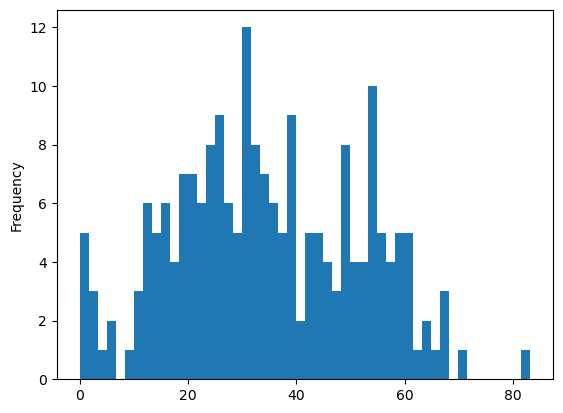

In [19]:
va2['No Vehicle Available'].plot.hist(bins=50)

Interesting! It seems like there is definitely a range with an average of around 40% of households without a car in DC.

## Converting vehicle ownership into a geodata frame
Now it's time to bring in vehicle tract data to be able to map it. First I will bring in the data. Next, I will join the census tracts to vehicle ownership data using GEOID.

In [20]:
tracts=gpd.read_file('data/Census_Tracts_in_2020.geojson')

Here's what the data looks like:

In [21]:
tracts.head()

,OBJECTID,TRACT,GEOID,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,...,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,SHAPEAREA,SHAPELEN,geometry
0,1,002002,11001002002,4072,3647,1116,1751,27,84,0,...,0,0,0,32,0,0,32,0,0,"POLYGON ((-77.03642 38.94975, -77.03643 38.948..."
1,2,002101,11001002101,5687,5071,1037,2642,86,120,1,...,0,0,0,31,0,0,31,0,0,"POLYGON ((-77.02824 38.95813, -77.02824 38.958..."
2,3,002102,11001002102,5099,4599,901,2910,50,87,0,...,0,0,0,145,0,0,145,0,0,"POLYGON ((-77.01997 38.95819, -77.01997 38.958..."
3,4,002201,11001002201,3485,3138,973,1722,21,94,2,...,6,0,0,0,0,0,0,0,0,"POLYGON ((-77.02743 38.95188, -77.02740 38.951..."
4,5,002202,11001002202,3339,2957,619,1636,48,57,3,...,0,0,0,4,0,0,4,0,0,"POLYGON ((-77.01968 38.95209, -77.01963 38.951..."


I want to see the breakdown of Census Tracts in DC and see what it looks like on a map:

<AxesSubplot: >

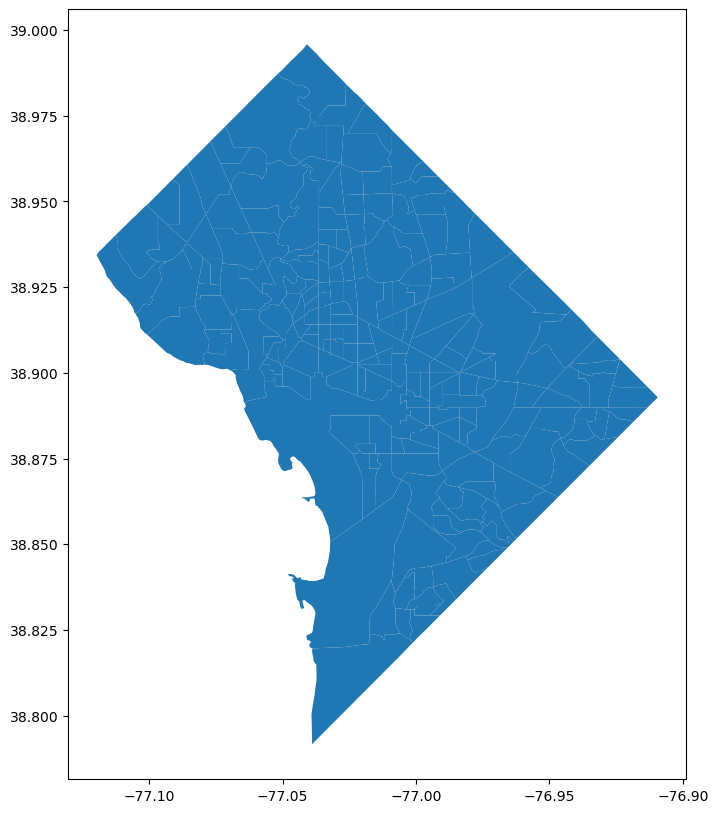

In [22]:
tracts.plot(figsize=(12,10))

Now let's see what type of data we are working with:

In [23]:
tracts.info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 316 columns):
 #    Column     Non-Null Count  Dtype   
---   ------     --------------  -----   
 0    OBJECTID   206 non-null    int64   
 1    TRACT      206 non-null    object  
 2    GEOID      206 non-null    object  
 3    P0010001   206 non-null    int64   
 4    P0010002   206 non-null    int64   
 5    P0010003   206 non-null    int64   
 6    P0010004   206 non-null    int64   
 7    P0010005   206 non-null    int64   
 8    P0010006   206 non-null    int64   
 9    P0010007   206 non-null    int64   
 10   P0010008   206 non-null    int64   
 11   P0020002   206 non-null    int64   
 12   P0020005   206 non-null    int64   
 13   P0020006   206 non-null    int64   
 14   P0020007   206 non-null    int64   
 15   P0020008   206 non-null    int64   
 16   P0020009   206 non-null    int64   
 17   P0020010   206 non-null    int64   
 18   P0030001   206 non-null    int64   
 19 

Next, I will trim down the data to include only GEOID and geometry, which are the only two columns we will use.

In [24]:
tracts = tracts[['GEOID','geometry']]
tracts.head()

,GEOID,geometry
0,11001002002,"POLYGON ((-77.03642 38.94975, -77.03643 38.948..."
1,11001002101,"POLYGON ((-77.02824 38.95813, -77.02824 38.958..."
2,11001002102,"POLYGON ((-77.01997 38.95819, -77.01997 38.958..."
3,11001002201,"POLYGON ((-77.02743 38.95188, -77.02740 38.951..."
4,11001002202,"POLYGON ((-77.01968 38.95209, -77.01963 38.951..."


Next, I will merge the vehicle access data along GEOID.

In [25]:
tracts_vehicle=tracts.merge(va2,on="GEOID")

Let's double check that it worked:

In [26]:
tracts_vehicle.head()

,GEOID,geometry,No Vehicle Available,1 Vehicle Available,2 Vehicles Available,3 Vehicles Available,4 Vehicles Available,5 or More Vehicles Available
0,11001002002,"POLYGON ((-77.03642 38.94975, -77.03643 38.948...",12.02,50.00,27.09,6.91,1.00,2.99
1,11001002101,"POLYGON ((-77.02824 38.95813, -77.02824 38.958...",23.75,47.32,23.13,0.96,4.02,0.83
2,11001002102,"POLYGON ((-77.01997 38.95819, -77.01997 38.958...",23.18,44.99,31.16,0.66,0.00,0.00
3,11001002201,"POLYGON ((-77.02743 38.95188, -77.02740 38.951...",13.28,43.04,28.91,8.57,6.21,0.00
4,11001002202,"POLYGON ((-77.01968 38.95209, -77.01963 38.951...",23.20,44.73,12.80,19.27,0.00,0.00


Now that the data is merged, I want to add another column that combines together all the columns that indicate that a household has access to a vehicle.

In [27]:
vehicle_columns=['1 Vehicle Available',
'2 Vehicles Available',
'3 Vehicles Available',
'4 Vehicles Available',
'5 or More Vehicles Available']
tracts_vehicle['Any Vehicle'] = tracts_vehicle[vehicle_columns].sum(axis=1)

Let's make sure it worked:

In [28]:
# let's see if it worked
tracts_vehicle.head()

,GEOID,geometry,No Vehicle Available,1 Vehicle Available,2 Vehicles Available,3 Vehicles Available,4 Vehicles Available,5 or More Vehicles Available,Any Vehicle
0,11001002002,"POLYGON ((-77.03642 38.94975, -77.03643 38.948...",12.02,50.00,27.09,6.91,1.00,2.99,87.99
1,11001002101,"POLYGON ((-77.02824 38.95813, -77.02824 38.958...",23.75,47.32,23.13,0.96,4.02,0.83,76.26
2,11001002102,"POLYGON ((-77.01997 38.95819, -77.01997 38.958...",23.18,44.99,31.16,0.66,0.00,0.00,76.81
3,11001002201,"POLYGON ((-77.02743 38.95188, -77.02740 38.951...",13.28,43.04,28.91,8.57,6.21,0.00,86.73
4,11001002202,"POLYGON ((-77.01968 38.95209, -77.01963 38.951...",23.20,44.73,12.80,19.27,0.00,0.00,76.80


Looks good! Let's move onto mapping the data:

## Cleaning up the Ward Map

I'm bringing in a geojson of the DC ward map (2012) to overlay on top of the map.

In [29]:
wards=gpd.read_file('data/Wards_from_2012.geojson')

Let's make sure the ward information was brought in with all the information we need.

In [30]:
wards.head()

,OBJECTID,WARD,NAME,REP_NAME,WEB_URL,REP_PHONE,REP_EMAIL,REP_OFFICE,WARD_ID,LABEL,...,BACH_DEGREE_25_PLUS,MED_VAL_OOU,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,SHAPEAREA,SHAPELEN,geometry
0,1,6,Ward 6,Charles Allen,https://www.dccouncil.us/council/councilmember...,(202) 724-8072,callen@dccouncil.us,"1350 Pennsylvania Ave, Suite 406, NW 20004",6,Ward 6,...,19588,573200,{5D2A5470-9BA3-4C94-9A21-46B5DBFF70D4},None,None,None,None,0,0,"POLYGON ((-77.01790 38.91410, -77.01801 38.914..."
1,2,8,Ward 8,"Trayon White, Sr.",https://www.dccouncil.us/council/councilmember...,(202) 724-8045,twhite@dccouncil.us,"1350 Pennsylvania Ave, Suite 400, NW 20004",8,Ward 8,...,3781,229900,{47803E60-D3B3-4445-A139-9456F9B20BED},None,None,None,None,0,0,"POLYGON ((-76.97229 38.87286, -76.97240 38.872..."
2,3,4,Ward 4,Janeese Lewis George,https://dccouncil.us/council/ward-4-councilmem...,(202) 724-8052,jlewisgeorge@dccouncil.us,"1350 Pennsylvania Ave, Suite 105, NW 20004",4,Ward 4,...,13032,491300,{C0E0D035-7F66-4819-887B-1575851278F3},None,None,None,None,0,0,"POLYGON ((-77.04097 38.99597, -77.07174 38.971..."
3,4,3,Ward 3,Mary M. Cheh,https://www.dccouncil.us/council/council-membe...,(202) 724-8062,mcheh@dccouncil.us,"1350 Pennsylvania Ave, Suite 108, NW 20004",3,Ward 3,...,19166,823800,{E6E33839-8446-458B-B7E9-BE071089193C},None,None,None,None,0,0,"POLYGON ((-77.05808 38.95676, -77.05809 38.956..."
4,5,5,Ward 5,Kenyan McDuffie,https://dccouncil.us/council/kenyan-mcduffie,(202) 724-8028,kmcduffie@dccouncil.us,"1350 Pennsylvania Ave, Suite 506, NW 20004",5,Ward 5,...,11557,379800,{7969341D-A3BD-4D6B-8257-F5DE354D001A},None,None,None,None,0,0,"POLYGON ((-76.99144 38.95730, -76.99163 38.957..."


There's a lot of cool information here but I think I'll only need 'WARD' and 'geometry' so I'll cut out the rest.

In [31]:
trim_columns=['WARD','NAME','geometry']
wards_trimmed = wards[trim_columns].copy()
wards_trimmed = wards_trimmed.dropna()
wards_trimmed.sample

<bound method NDFrame.sample of    WARD    NAME                                           geometry
0     6  Ward 6  POLYGON ((-77.01790 38.91410, -77.01801 38.914...
1     8  Ward 8  POLYGON ((-76.97229 38.87286, -76.97240 38.872...
2     4  Ward 4  POLYGON ((-77.04097 38.99597, -77.07174 38.971...
3     3  Ward 3  POLYGON ((-77.05808 38.95676, -77.05809 38.956...
4     5  Ward 5  POLYGON ((-76.99144 38.95730, -76.99163 38.957...
5     1  Ward 1  POLYGON ((-77.03523 38.93743, -77.03570 38.937...
6     2  Ward 2  POLYGON ((-77.04946 38.91999, -77.04973 38.920...
7     7  Ward 7  POLYGON ((-76.94186 38.91854, -76.94200 38.918...>

Now let's see what the ward boundaries look like...

<AxesSubplot: >

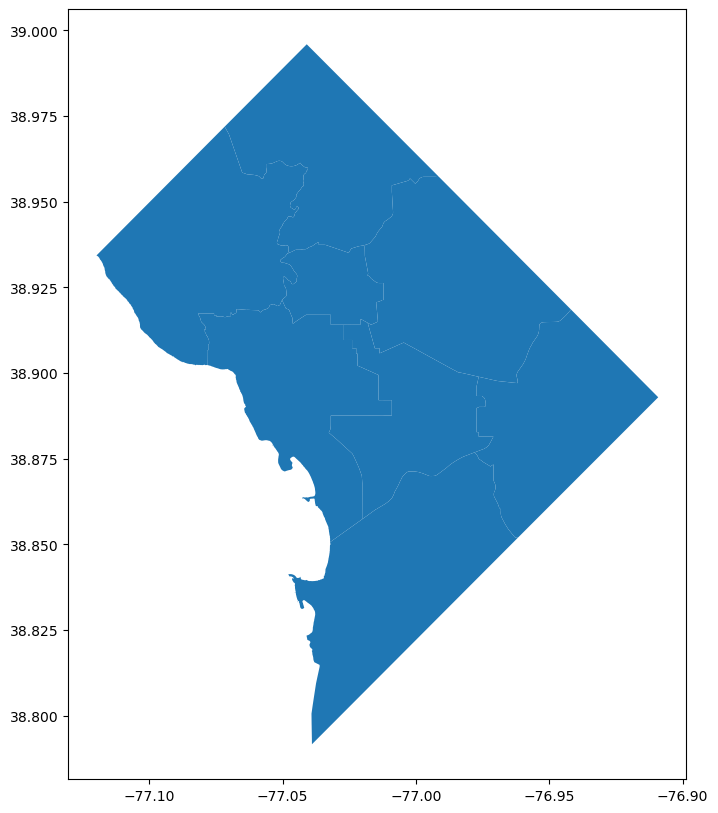

In [32]:
wards_trimmed.plot(figsize=(12,10))

Let's double check the projections to make sure we're all on the same page.

In [33]:
wards_trimmed.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Since we'll be working with distances, I want to convert this into CRS 3857 

In [34]:
wards_trimmed = wards_trimmed.to_crs(epsg=3857)

In [35]:
wards_trimmed.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now that we've done that, we can overlay the ward map on top of the vehicle access map.

## Mapping Vehicle Access by Ward

Bringing everything together now.

First, I want to check the projection of the vehicle access data and keep it in 3857

In [36]:
tracts_vehicle.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Let's convert it to EPSG 3857 because the projection will be cleaner for the map.

In [37]:
tracts_vehicle_new = tracts_vehicle.to_crs(epsg=3857)

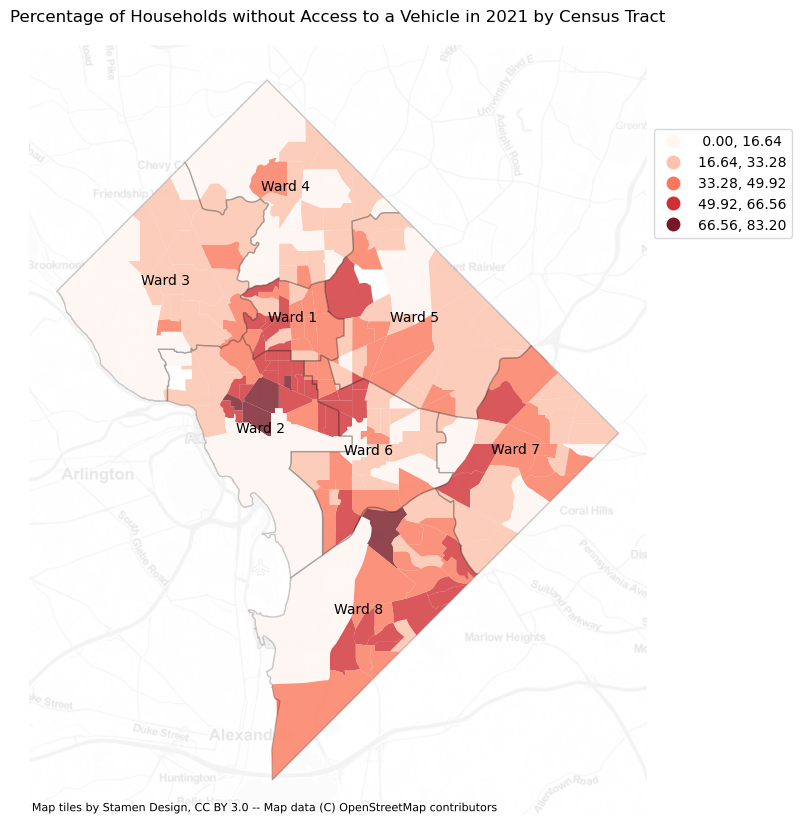

In [55]:
fig, ax = plt.subplots(figsize=(10,10))

tracts_vehicle_new.plot(figsize=(12,10),
                        column='No Vehicle Available',
                        legend=True,
                        cmap='Reds',
                        ax=ax,
                        legend_kwds={'loc':'upper left','bbox_to_anchor':(1,.9)},
                        scheme='equal_interval', alpha=0.9)

wards_trimmed.plot(ax=ax,
                   color='white', 
                   edgecolor='black',
                   alpha=0.2)

wards_trimmed.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

ax.axis('off')

ax.set_title('Percentage of Households without Access to a Vehicle in 2021 by Census Tract')

ctx.add_basemap(ax=ax,
                crs=3857,
                source=ctx.providers.Stamen.TonerLite,
                alpha=0.1 # add transparency to make it less dominant
                )